In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, lda_utils
from bs4 import BeautifulSoup
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

from datetime import datetime
from wordcloud import WordCloud

from collections import Counter

In [50]:
# nltk.download('wordnet')

contracted_words_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Wall Street Forum

## EDA - Raw Data

In [6]:
wallstreet = pd.read_csv('data/wallstreet.csv')

In [7]:
wallstreet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45372 entries, 0 to 45371
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                45372 non-null  int64 
 1   threadID              45372 non-null  int64 
 2   threadTitle           45370 non-null  object
 3   URL                   45372 non-null  object
 4   subforum              45372 non-null  object
 5   authorName            45372 non-null  object
 6   postAuthorMembership  45372 non-null  object
 7   postAuthorJoinDate    45372 non-null  object
 8   authorReputation      45372 non-null  int64 
 9   postDate              45372 non-null  object
 10  postSequence          45372 non-null  int64 
 11  likes                 45372 non-null  int64 
 12  flatContent           45372 non-null  object
 13  contentWithHTMLTag    45372 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.8+ MB


In [8]:
wallstreet.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag
0,6,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,Punka421,New member,2016-10-26,-3,2016-10-26 13:58:36,1,0,\nJust thought I'd introduce myself. I am new ...,"<div class=""entry-content"">\n<p>Just thought I..."
1,7,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,WSM,Administrator,2016-10-02,66,2016-10-26 14:04:04,2,0,\nHello Nice to see you here!Regards\n,"<div class=""entry-content"">\n<p>Hello <img alt..."
2,8,6,WSM Updates - Changelog (Page 1 of 4),http://x7bwsmcore5fmx56.onion/viewtopic.php?id=6,Announcements,WSM,Administrator,2016-10-02,74,2016-10-26 16:54:27,1,0,\nHello everyone.I would like to tell you that...,"<div class=""entry-content"">\n<p>Hello everyone..."
3,11,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,Estrazy,Banned,2016-10-27,0,2016-10-27 14:00:16,3,0,\nHello Punka! nice to meet you!As you asked h...,"<div class=""entry-content"">\n<p>Hello Punka! n..."
4,13,6,WSM Updates - Changelog (Page 1 of 4),http://x7bwsmcore5fmx56.onion/viewtopic.php?id=6,Announcements,WSM,Administrator,2016-10-02,74,2016-11-02 15:42:27,2,0,"\nChangelog from Wednesday, 2nd November 2016F...","<div class=""entry-content"">\n<h5>Changelog fro..."


In [9]:
total_num_posts_wall = wallstreet.shape[0] 
print('# of Postings: ', total_num_posts_wall)
print('# of Unique Threads : ', len(wallstreet['threadID'].unique()))
print('# of Unique Subforums : ', len(wallstreet['subforum'].unique()))
print('# of Unique Authors : ', len(wallstreet['authorName'].unique()))
print('# of Membership Types : ', len(wallstreet['postAuthorMembership'].unique()))

# of Postings:  45372
# of Unique Threads :  8755
# of Unique Subforums :  40
# of Unique Authors :  5533
# of Membership Types :  8


In [10]:
wall_authors = pd.DataFrame(wallstreet['authorName'].value_counts()).reset_index()
wall_authors.columns = ['author','num_postings']
wall_authors['prcnt_total_posts'] = wall_authors['num_postings'] / total_num_posts_wall
wall_authors.head(10)

,author,num_postings,prcnt_total_posts
0,med3l1n,4889,0.107754
1,6LACK,1500,0.033060
2,leaguemode,1146,0.025258
3,ExpectUS,1113,0.024531
4,PurityRing,1111,0.024486
5,BonesKoopa,476,0.010491
6,Icepapi,446,0.009830
7,code48k,379,0.008353
8,deusxmacina,354,0.007802
9,dabbingtimes,334,0.007361


In [11]:
wall_threads = pd.DataFrame(wallstreet['threadTitle'].value_counts()).reset_index()
wall_threads.columns = ['thread_topic','num_postings']
wall_threads['prcnt_total_posts'] = wall_threads['num_postings'] / total_num_posts_wall
wall_threads.head(10)

,thread_topic,num_postings,prcnt_total_posts
0,GozNym 2.0 Banking Bot (Page 1 of 3),75,0.001653
1,GozNym 2.0 Banking Bot (Page 2 of 3),75,0.001653
2,[Price & Version update] BTC ATM Malware,73,0.001609
3,GozNym 2.0 Banking Bot (Page 3 of 3),56,0.001234
4,Hello,52,0.001146
5,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
6,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
7,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
8,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
9,CASHAPP GUIDE,50,0.001102


In [12]:
wall_subforums = pd.DataFrame(wallstreet['subforum'].value_counts()).reset_index()
wall_subforums.columns = ['subforum','num_postings']
wall_subforums['prcnt_total_posts'] = wall_subforums['num_postings'] / total_num_posts_wall
wall_subforums.head(10)

,subforum,num_postings,prcnt_total_posts
0,Fraud,12277,0.270585
1,General Questions,5225,0.115159
2,Carding Stuff,3836,0.084546
3,Services,2973,0.065525
4,Cannabis,2431,0.053579
5,Introductions,2418,0.053293
6,Counterfeits,1727,0.038063
7,Stimulants,1537,0.033876
8,Announcements,1507,0.033214
9,Digital goods,1443,0.031804


In [13]:
wall_joindate = pd.DataFrame(wallstreet['postAuthorJoinDate'].value_counts()).reset_index()
wall_joindate.columns = ['join_date','count']
wall_joindate['prcnt_total_posts'] = wall_joindate['count'] / total_num_posts_wall
wall_joindate.head(10)

,join_date,count,prcnt_total_posts
0,Despacitoland,4889,0.107754
1,G,1500,0.033060
2,2017-11-06,1227,0.027043
3,2018-01-10,1146,0.025258
4,InterWebz,1113,0.024531
5,2017-07-27,524,0.011549
6,2018-03-03,498,0.010976
7,2017-11-09,427,0.009411
8,2018-05-06,415,0.009147
9,2017-10-17,403,0.008882


C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


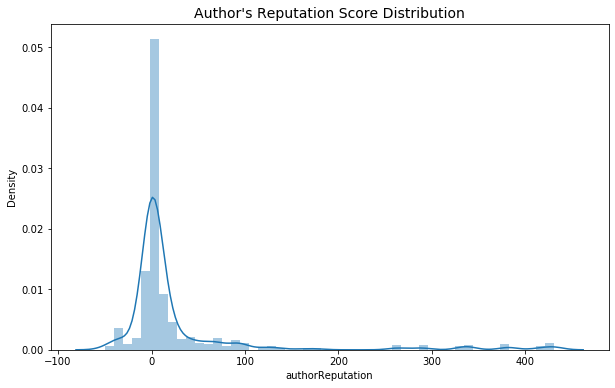

In [14]:
# Max value ~ 5,400.
constraint = 500
reputation = wallstreet[wallstreet['authorReputation'] < constraint]['authorReputation']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(reputation)
ax.set_title("Author's Reputation Score Distribution", fontsize=14);

C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


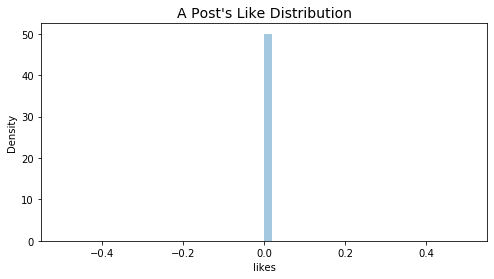

In [15]:
constraint = 100
likes = wallstreet[wallstreet['likes'] < constraint]['likes']
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.distplot(likes)
ax.set_title("A Post's Like Distribution", fontsize=14);

---
## Data Processing / Feature Engineering

In [91]:
# wsm = Wall Street Market
addtl_stopwords = ['still', 'got', 'guy', 'say', 'still', 'thing', 'us', 'will', 'get', '']

stopwords = stopwords.words("english")#.append(append_to_stopwords)
stopwords = stopwords + addtl_stopwords
stopwords_dict = Counter(stopwords)

# List of punctuation
punc = list(set(string.punctuation))

In [86]:
print(stopwords.words("english")print(stopwords.words('english')))

AttributeError: 'list' object has no attribute 'words'

In [93]:
print(stopwords_dict)

Counter({'will': 2, 'still': 2, 'i': 1, 'me': 1, 'my': 1, 'myself': 1, 'we': 1, 'our': 1, 'ours': 1, 'ourselves': 1, 'you': 1, "you're": 1, "you've": 1, "you'll": 1, "you'd": 1, 'your': 1, 'yours': 1, 'yourself': 1, 'yourselves': 1, 'he': 1, 'him': 1, 'his': 1, 'himself': 1, 'she': 1, "she's": 1, 'her': 1, 'hers': 1, 'herself': 1, 'it': 1, "it's": 1, 'its': 1, 'itself': 1, 'they': 1, 'them': 1, 'their': 1, 'theirs': 1, 'themselves': 1, 'what': 1, 'which': 1, 'who': 1, 'whom': 1, 'this': 1, 'that': 1, "that'll": 1, 'these': 1, 'those': 1, 'am': 1, 'is': 1, 'are': 1, 'was': 1, 'were': 1, 'be': 1, 'been': 1, 'being': 1, 'have': 1, 'has': 1, 'had': 1, 'having': 1, 'do': 1, 'does': 1, 'did': 1, 'doing': 1, 'a': 1, 'an': 1, 'the': 1, 'and': 1, 'but': 1, 'if': 1, 'or': 1, 'because': 1, 'as': 1, 'until': 1, 'while': 1, 'of': 1, 'at': 1, 'by': 1, 'for': 1, 'with': 1, 'about': 1, 'against': 1, 'between': 1, 'into': 1, 'through': 1, 'during': 1, 'before': 1, 'after': 1, 'above': 1, 'below': 1, 't

In [94]:
def parse_html_remove_url(text):   
    '''
    Parse html and removes internet-related vestige.
    '''
    
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'http\S+', '', text)
    return text

def expand_contractions(text, contractions_map):
    '''
    Expands contracted words
    '''
    
    text_arr = []
    text = text.split(' ')
    for t in text:
        if t in contractions_map:
            text_arr.append(contractions_map[t])
        else:
            text_arr.append(t)
    
    revised_text = ' '.join(text_arr)
    
    return revised_text

In [95]:
def process_text(text, contractions_map, punc, stopwords):
    '''
    
    
    '''
    text = parse_html_remove_url(text)
    text = expand_contractions(text, contractions_map)
    text = re.sub(r'\w*\d\w*', '', text)
    
    tokens = TweetTokenizer().tokenize(text)
    tokens = [t for t in tokens if t not in punc]
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if len(t) > 1]
    tokens = [t for t in tokens if t != ' ']
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

In [96]:
def parse_clean(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

def tokenize_lemmatize(text):
    '''
    
    
    Args:
        comment (str) : Content of the author's post in Wall Street Market.
        
    Return:
        lem_tokens (arr) : The cleaned, tokenized and lemmetized version of comment.
        
    '''
    
    
    
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_dict]
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

In [97]:
def prep_text_for_wordcloud(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    #punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    text = parse_html_remove_url(text)
    text = expand_contractions(text, contracted_words_dict)
    text = re.sub(r"[^\w\s]", '', text)
    # Removes key ids.
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_dict]
    joined_tokens = ' '.join(tokens)
    
    return joined_tokens

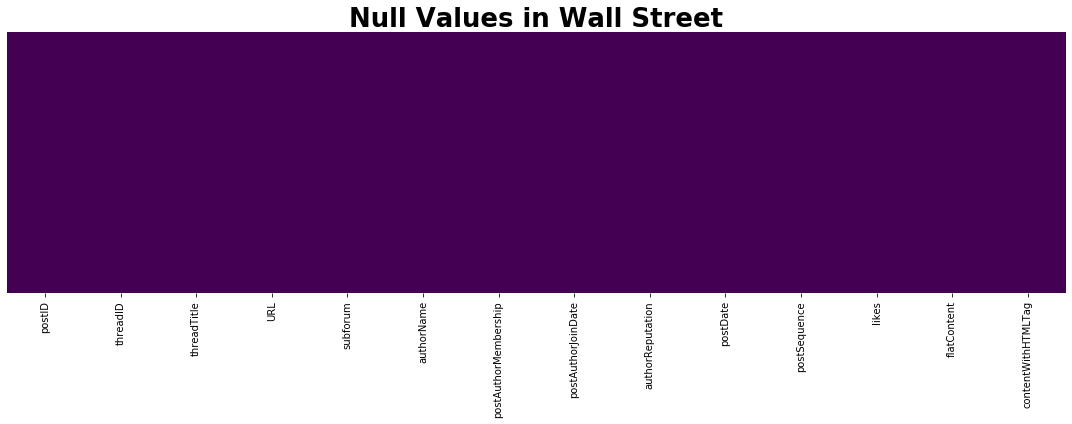

In [98]:
utils.plot_null_val_heatmap(wallstreet, 'Null Values in Wall Street', (15,6))

In [99]:
wallstreet_v2 = wallstreet.copy()

In [100]:
wallstreet_v2['post_date_dt'] = wallstreet_v2['postDate'].apply(utils.fix_postdate_col)
wallstreet_v2['author_join_date'] = wallstreet_v2.apply(lambda x: utils.fix_author_join_date_col(x['postAuthorJoinDate'], x['postAuthorMembership'], x['post_date_dt']), axis=1)
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['post_date_dt'].dt.date - wallstreet_v2['author_join_date'].dt.date
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['num_days_member_when_posted'].dt.days

In [101]:
cols_to_drop = ['URL', 'likes', 'postDate', 'postAuthorJoinDate', 'flatContent']
wallstreet_v2.drop(cols_to_drop, axis=1, inplace=True)

In [102]:
wallstreet_v3 = wallstreet_v2.copy()

In [103]:
wallstreet_v3['wordcloud_text'] = wallstreet_v3['contentWithHTMLTag'].apply(prep_text_for_wordcloud)

In [104]:
wallstreet_v3['cleaned_text'] = wallstreet_v3['contentWithHTMLTag'].apply(parse_clean)
wallstreet_v3['lemmatized_tokens'] = wallstreet_v3['cleaned_text'].apply(tokenize_lemmatize)

In [105]:
wallstreet_v3['processed_text'] = wallstreet_v3['contentWithHTMLTag'].apply(lambda x: process_text(x, contracted_words_dict, punc, stopwords_dict))

In [106]:
wallstreet_v3.head()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,contentWithHTMLTag,post_date_dt,author_join_date,num_days_member_when_posted,wordcloud_text,cleaned_text,lemmatized_tokens,processed_text
0,6,5,Hi,Introductions,Punka421,New member,-3,1,"<div class=""entry-content"">\n<p>Just thought I...",2016-10-26 13:58:36,2016-10-26,0.0,thought I would introduce new communities tryi...,just thought id introduce myself i am new to ...,"[thought, id, introduce, new, community, tryin...","[thought, would, introduce, new, community, tr..."
1,7,5,Hi,Introductions,WSM,Administrator,66,2,"<div class=""entry-content"">\n<p>Hello <img alt...",2016-10-26 14:04:04,2016-10-02,24.0,hello nice see hereregards,hello nice to see you hereregards,"[hello, nice, see, hereregards]","[hello, nice, see, regard]"
2,8,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,1,"<div class=""entry-content"">\n<p>Hello everyone...",2016-10-26 16:54:27,2016-10-02,24.0,hello everyonei would like tell implemented ne...,hello everyonei would like to tell you that w...,"[hello, everyonei, would, like, tell, weve, im...","[hello, everyone, would, like, tell, implement..."
3,11,5,Hi,Introductions,Estrazy,Banned,0,3,"<div class=""entry-content"">\n<p>Hello Punka! n...",2016-10-27 14:00:16,2016-10-27,0.0,hello punka nice meet youas asked stay secure ...,hello punka nice to meet youas you asked how ...,"[hello, punka, nice, meet, youas, asked, stay,...","[hello, punka, nice, meet, asked, stay, secure..."
4,13,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,2,"<div class=""entry-content"">\n<h5>Changelog fro...",2016-11-02 15:42:27,2016-10-02,31.0,changelog wednesday november lot small issues ...,changelog from wednesday november a lot of ...,"[changelog, wednesday, november, lot, small, i...","[changelog, wednesday, november, lot, small, i..."


In [107]:
wallstreet_v3.tail()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,contentWithHTMLTag,post_date_dt,author_join_date,num_days_member_when_posted,wordcloud_text,cleaned_text,lemmatized_tokens,processed_text
45367,71451,20321,Opening Leases,Fraud,24kings,Member,-1,1,"<div class=""entry-content"">\n<p>i am planning ...",2018-11-14 17:33:55,2018-05-13,185.0,planning opening leases middleclass community ...,i am planning on opening a few leases in a mi...,"[planning, opening, lease, middleclass, commun...","[planning, opening, lease, middle-class, commu..."
45368,71454,20321,Opening Leases,Fraud,JGX7TRE,New member,0,2,"<div class=""entry-content"">\n<p>depends on if ...",2018-11-14 18:20:27,2018-11-14,0.0,depends landlord credit check landlords rent g...,depends on if the landlord does a credit chec...,"[depends, landlord, credit, check, landlord, r...","[depends, landlord, credit, check, landlord, r..."
45369,71455,19423,"Utility bills, bank statements and European PP...",Fraud,makarich,New member,0,2,"<div class=""entry-content"">\n<p>Do you make UK...",2018-11-14 18:21:54,2018-11-14,0.0,make uk documents specific companies banks sta...,do you make uk documents can you do specific ...,"[make, uk, document, specific, company, bank, ...","[make, uk, document, specific, company, bank, ..."
45370,71457,20187,Need legit USA CVV seller,Digital goods,fuckshit123,New member,0,8,"<div class=""entry-content"">\n<p>Please stop al...",2018-11-14 19:01:06,2018-11-12,2.0,please stop allowing identity theft concern ra...,please stop allowing identity theft before yo...,"[please, stop, allowing, identity, theft, conc...","[please, stop, allowing, identity, theft, conc..."
45371,71458,20321,Opening Leases,Fraud,ExpectUS,Vendor,1330,3,"<div class=""entry-content"">\n<div class=""quote...",2018-11-14 19:04:50,NaT,NaN,wrotei planning opening leases middleclass com...,wrotei am planning on opening a few leases i...,"[wrotei, planning, opening, lease, middleclass...","[wrote, planning, opening, lease, middle-class..."


In [108]:
wallstreet_v3.to_csv('data/wallstreet_master.csv', index=False)

---
# EDA using Engineering Features

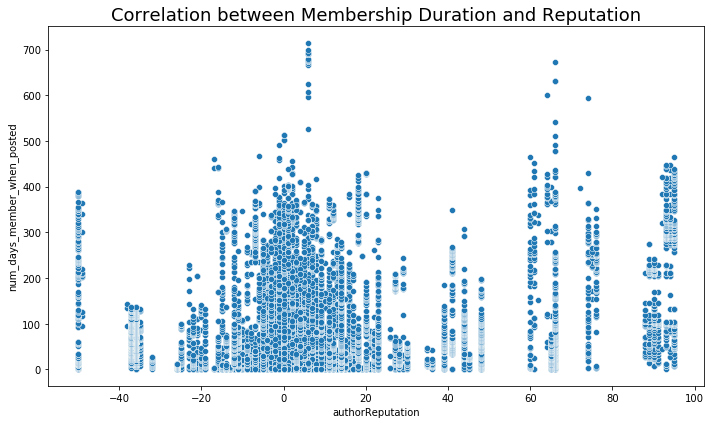

In [26]:
rep_limit = 500
excl_rep_outliers = wallstreet_v3[wallstreet_v3['authorReputation'] < rep_limit]

plt.figure(figsize=(10,6))

sns.scatterplot(y='num_days_member_when_posted', x='authorReputation', data=excl_rep_outliers)
plt.title('Correlation between Membership Duration and Reputation', fontsize=18)
plt.tight_layout();

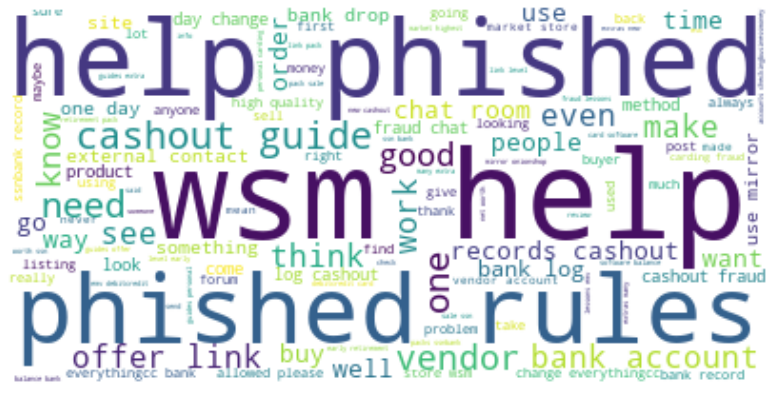

In [109]:
max_words=100000
joined_wordcloud_text = ' '.join(wallstreet_v3['wordcloud_text'])

wordcloud = WordCloud(background_color='white', max_words=max_words, contour_color='steelblue')
wordcloud.generate(joined_wordcloud_text)

plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

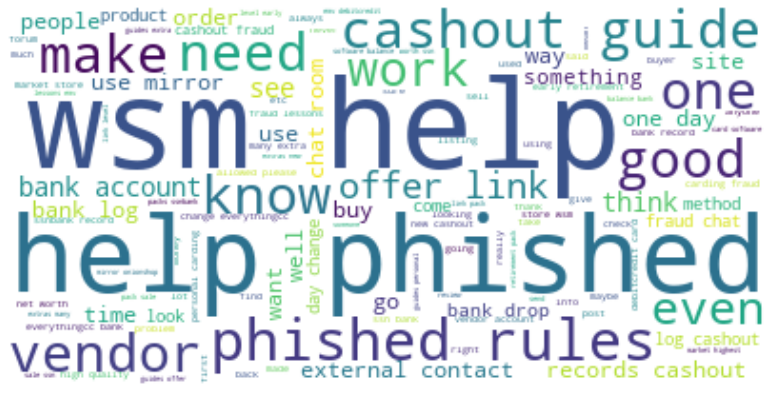

In [110]:
max_words=100000
rel_scaling = 0
joined_wordcloud_text = ' '.join(wallstreet_v3['wordcloud_text'])

wordcloud = WordCloud(background_color='white', max_words=max_words, relative_scaling=rel_scaling, contour_color='steelblue')
wordcloud.generate(joined_wordcloud_text)

plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

---

In [111]:
wallstreet_v3['wordcloud_text_v2'] = wallstreet_v3['processed_text'].apply(lambda x: ' '.join(x))


In [112]:
wallstreet_v3['wordcloud_text_v2']

0        thought would introduce new community trying l...
1                                    hello nice see regard
2        hello everyone would like tell implemented new...
3        hello punka nice meet asked stay secure tip ca...
4        changelog wednesday november lot small issue b...
                               ...                        
45367    planning opening lease middle-class community ...
45368    depends landlord credit check landlord rent go...
45369    make uk document specific company bank stateme...
45370    please stop allowing identity theft concern ra...
45371    wrote planning opening lease middle-class comm...
Name: wordcloud_text_v2, Length: 45372, dtype: object

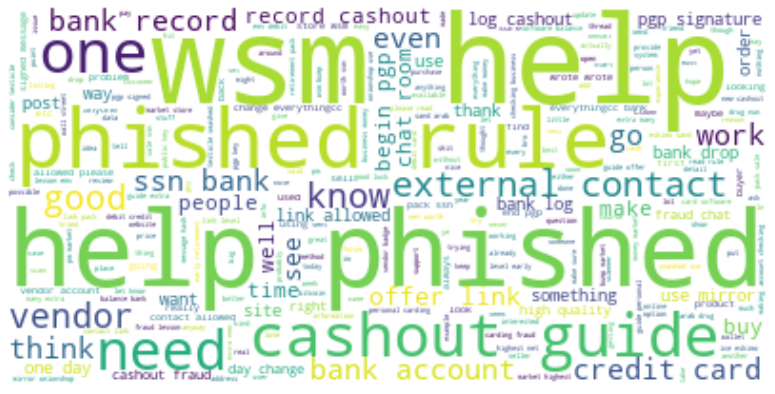

In [113]:
max_words=100000
rel_scaling = 0
joined_wordcloud_text = ' '.join(wallstreet_v3['wordcloud_text_v2'])

wordcloud = WordCloud(background_color='white', max_words=max_words, contour_color='steelblue')
wordcloud.generate(joined_wordcloud_text)

plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [119]:
all_words_arr = joined_wordcloud_text.split(' ')
word_freq_df = pd.DataFrame(pd.Series(all_words_arr).value_counts()).reset_index()
word_freq_df.columns = ['word', 'freq'] 

In [120]:
word_freq_df

,word,freq
0,wrote,14028
1,vendor,13236
2,bank,12130
3,market,11943
4,account,11030
...,...,...
75740,smt,1
75741,peoplemeet,1
75742,reliableyesss,1
75743,equal-sized,1


In [ ]:
top20_words = words_sorted_prevalence_df[:20]
fig, ax = plt.subplots(figsize=(20,8))

ax = sns.barplot(x='word', y='freq', data=word_freq_df, palette='crest')
ax.set_title('Word Frequency', fontsize=22)
ax.set_xlabels('Words')
ax.set_ylabels('Frequency')

plt.tight_layout();